# Stock Price Prediction Project

## Overview
This project builds a machine learning model to predict the next day’s closing price of a stock using its historical closing price data.

**Steps:**
1. Import Stock price data.
2. Create features such as moving averages and daily returns.
3. Visualize stock price with features
4. Train a linear regression model.
5. Evaluate performance using MAE, RMSE, and R² score.
6. Visualize predictions vs. actual prices.
7. Trading simulation

## Install required Packages/Libraries

In [1]:
!pip install pandas numpy matplotlib yfinance scikit-learn -q
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Download Stock Data  
Use yfinance to get historical prices for the selected ticker symbol.

In [2]:
ticker = "AAPL"  # Can change this to any stock symbol
stock_data = yf.download(ticker, start="2020-01-01", end="2025-07-01", auto_adjust=True, progress=False)

# Display the first few rows
stock_data.head()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.538521,72.598899,71.292311,71.545897,135480400
2020-01-03,71.833305,72.594071,71.608700,71.765682,146322800
2020-01-06,72.405670,72.444313,70.703005,70.954181,118387200
2020-01-07,72.065163,72.671356,71.845385,72.415353,108872000
2020-01-08,73.224396,73.526287,71.768071,71.768071,132079200


## Data Cleaning and Feature Engineering

- Checked for missing values and dropped incomplete rows.
- Created new features to help the model:
  - Daily returns (percent change of closing price)
  - 7-day and 21-day moving averages
  - 7-day volatility of daily returns
- Drop rows with NaN values created by rolling calculations.

In [3]:
# Check for missing data
print("Missing values in each column:")
print(stock_data.isnull().sum().to_string())

# Fill or drop missing values if any
stock_data = stock_data.dropna()

# Daily returns = percentage change of Close price
stock_data['Daily Return'] = stock_data['Close'].pct_change()

# 7-day moving average of Close price
stock_data['MA_7'] = stock_data['Close'].rolling(window=7).mean()

# 21-day moving average of Close price
stock_data['MA_21'] = stock_data['Close'].rolling(window=21).mean()

# Volatility: rolling standard deviation of daily returns over 7 days
stock_data['Volatility_7'] = stock_data['Daily Return'].rolling(window=7).std()

# Drop rows with NaN created by rolling calculations
stock_data = stock_data.dropna()

# Show the first 5 rows with new features
stock_data.head()

Missing values in each column:
Price   Ticker
Close   AAPL      0
High    AAPL      0
Low     AAPL      0
Open    AAPL      0
Volume  AAPL      0


Price,Close,High,Low,Open,Volume,Daily Return,MA_7,MA_21,Volatility_7
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,,,
Date,,,,,,,,,
2020-01-31,74.750771,77.931496,74.456124,77.508848,199588400,-0.044339,76.659762,75.331901,0.025885
2020-02-03,74.545502,75.712008,72.990155,73.492500,173788400,-0.002746,76.295079,75.427471,0.025640
2020-02-04,77.006500,77.197298,75.745801,76.151541,136616400,0.033013,76.313709,75.673814,0.029343
2020-02-05,77.634430,78.433838,77.030647,78.134357,118826800,0.008154,76.744983,75.922803,0.026205
2020-02-06,78.542503,78.544921,77.347017,77.904912,105425600,0.011697,77.004433,76.231247,0.024548


## Visualizing Stock Price and Engineered Features

- Plot the historical Close Price alongside the 7-day and 21-day moving averages to observe price trends and smoothing effects.
- Plot the Daily Return and 7-day Volatility to analyze the stock’s day-to-day fluctuations and risk over time.

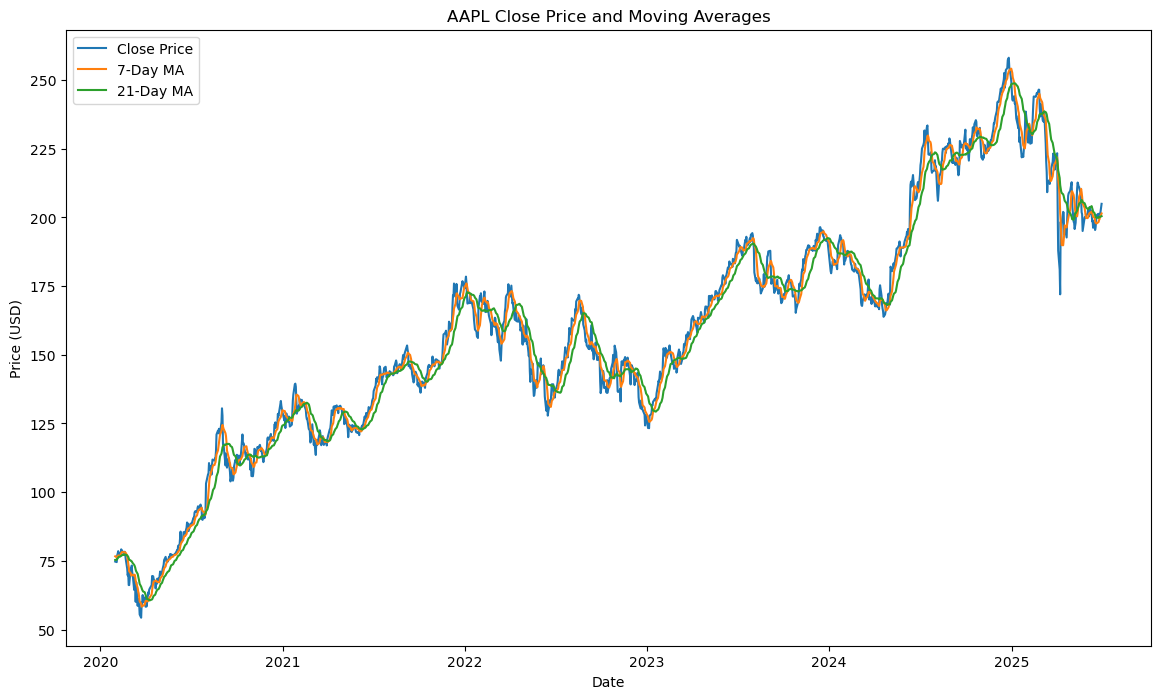

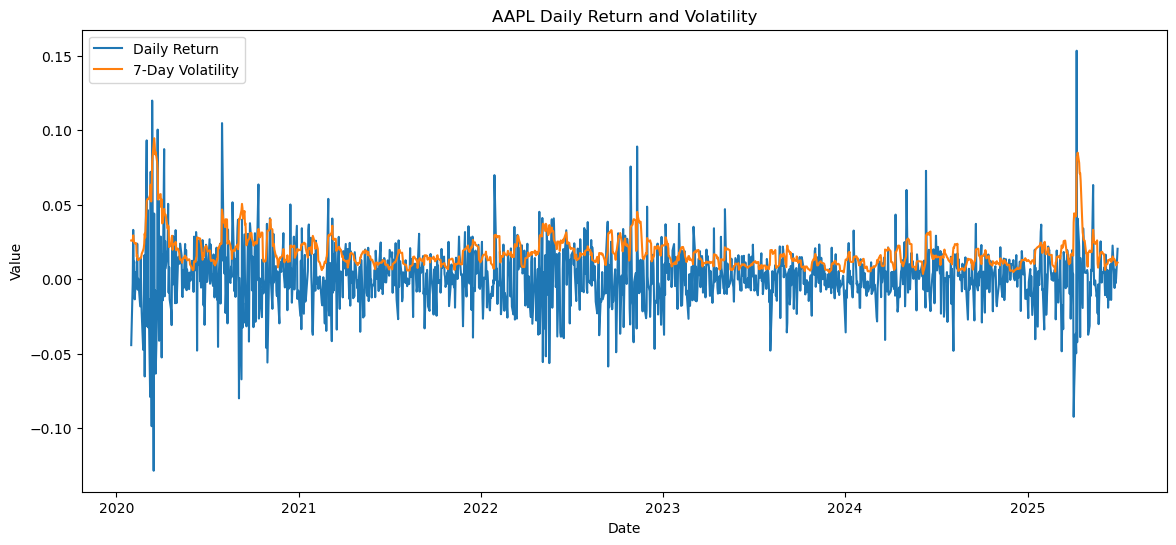

In [4]:
plt.figure(figsize=(14, 8))

# Plot Close price
plt.plot(stock_data.index, stock_data['Close'], label='Close Price')

# Plot moving averages
plt.plot(stock_data.index, stock_data['MA_7'], label='7-Day MA')
plt.plot(stock_data.index, stock_data['MA_21'], label='21-Day MA')

plt.title(f'{ticker} Close Price and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

# Plot Daily Return and Volatility
plt.figure(figsize=(14, 6))
plt.plot(stock_data.index, stock_data['Daily Return'], label='Daily Return')
plt.plot(stock_data.index, stock_data['Volatility_7'], label='7-Day Volatility')
plt.title(f'{ticker} Daily Return and Volatility')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

## Feature Preparation, Model Training, and Evaluation

- Flatten MultiIndex columns if present for easier access.
- Create key features based on closing price: daily returns, moving averages, and volatility.
- Prepare the target variable as the next day’s closing price.
- Split the dataset into training and testing sets (80/20), preserving time order.
- Train a Linear Regression model on the training data.
- Evaluate performance using Mean Squared Error (MSE) and R² score on test data.

In [5]:
# If columns are MultiIndex, flatten them to single-level
stock_data.columns = [' '.join(col).strip() if isinstance(col, tuple) else col for col in stock_data.columns]

# Create features
stock_data['Daily Return'] = stock_data['Close AAPL'].pct_change()
stock_data['MA_7'] = stock_data['Close AAPL'].rolling(window=7).mean()
stock_data['MA_21'] = stock_data['Close AAPL'].rolling(window=21).mean()
stock_data['Volatility_7'] = stock_data['Daily Return'].rolling(window=7).std()

# Drop NaNs created by rolling calculations before creating target
stock_data = stock_data.dropna()

# Create target variable (next day's closing price)
stock_data['Tomorrow Close'] = stock_data['Close AAPL'].shift(-1)

# Drop last row with NaN target
stock_data = stock_data.dropna()

# Select features and target
features = ['Close AAPL', 'MA_7', 'MA_21', 'Daily Return', 'Volatility_7']
X = stock_data[features]
y = stock_data['Tomorrow Close']

# Split data into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Squared Error: 17.9984
R² Score: 0.9274


## Model Performance Visualization and Metrics

- Plot the predicted stock prices against the actual prices over the test period to visually assess model accuracy.
- Calculate and display key regression metrics:
  - Mean Absolute Error (MAE): average magnitude of prediction errors.
  - Root Mean Squared Error (RMSE): penalizes larger errors more strongly.
  - R² Score: proportion of variance explained by the model.

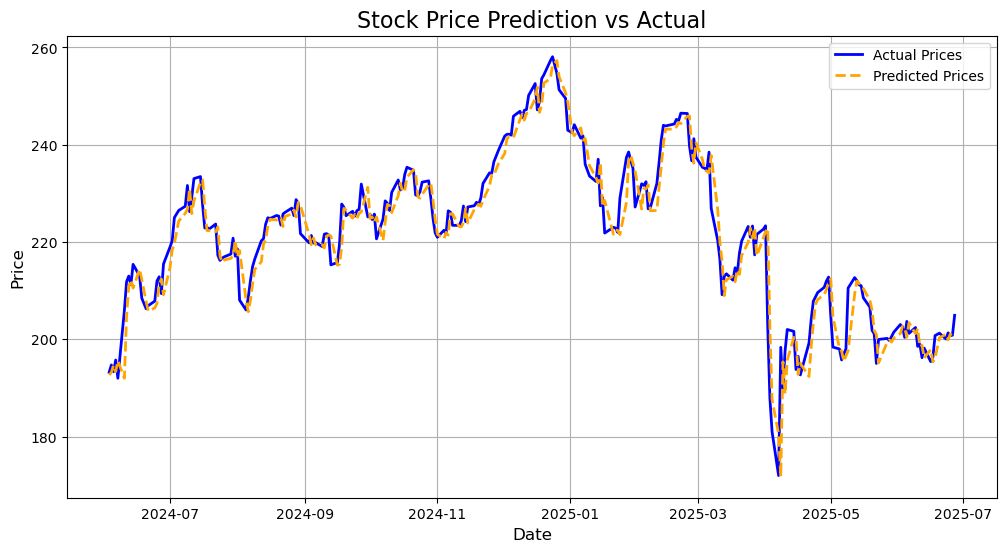

MAE: 2.95
RMSE: 4.24
R² Score: 0.9274


In [6]:
test_dates = X_test.index

plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test, label="Actual Prices", color="blue", linewidth=2)
plt.plot(test_dates, y_pred, label="Predicted Prices", color="orange", linestyle="--", linewidth=2)

plt.title("Stock Price Prediction vs Actual", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

## Scatter Plot: Predicted vs. Actual Prices

This plot compares the model’s predicted closing prices against the actual prices for the test set.

- Each point represents a single prediction.
- The red dashed line is the perfect prediction line (where predicted = actual).
- Points close to this line indicate accurate predictions.
- Deviations from the line show prediction errors or bias.

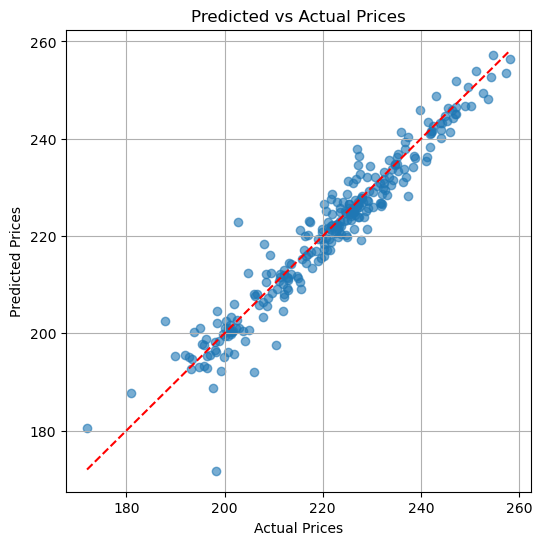

In [7]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Predicted vs Actual Prices")
plt.grid(True)
plt.show()

## Simple Trading Strategy Simulation

- Buy if predicted price > current price, sell if predicted price < current price.
- Track portfolio value over time and compare to buy-and-hold baseline.
- Evaluate performance using cumulative return and visualizations.

Cumulative Return: 15.31%


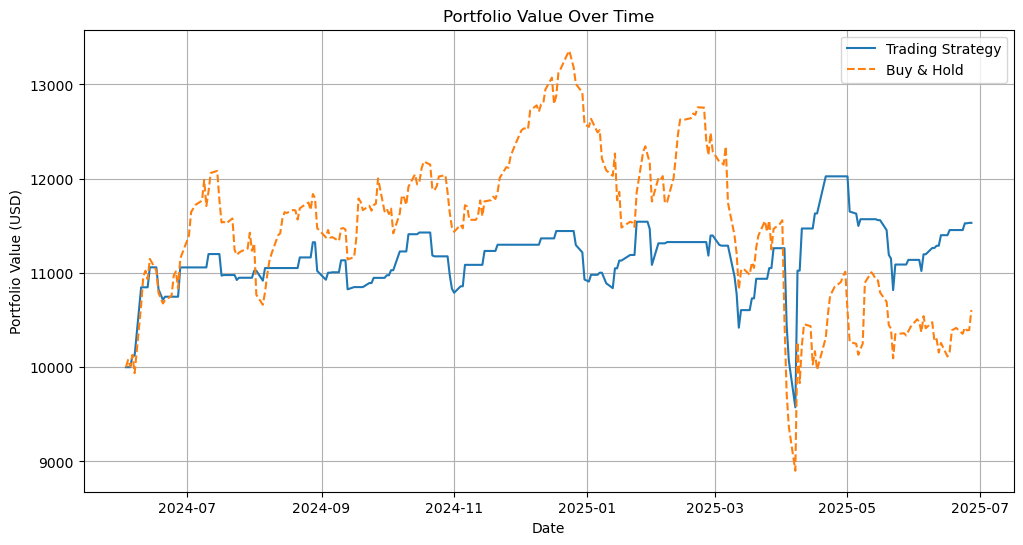

In [8]:
initial_capital = 10000  # Starting cash in USD
cash = initial_capital
shares = 0
portfolio_values = []

# Loop through test set
for i in range(len(y_test)):
    actual_price = y_test.iloc[i]
    predicted_price = y_pred[i]
    
    # Buy signal: predicted price > current price
    if predicted_price > actual_price:
        # Buy as many shares as possible with available cash
        shares_to_buy = cash // actual_price
        cash -= shares_to_buy * actual_price
        shares += shares_to_buy
        
    # Sell signal: predicted price < current price
    elif predicted_price < actual_price:
        # Sell all shares
        cash += shares * actual_price
        shares = 0
    
    # Calculate total portfolio value
    portfolio_value = cash + shares * actual_price
    portfolio_values.append(portfolio_value)

# Create DataFrame to track portfolio
portfolio_df = pd.DataFrame({
    'Date': X_test.index,
    'Portfolio Value': portfolio_values
}).set_index('Date')

# Calculate cumulative return
cumulative_return = (portfolio_values[-1] - initial_capital) / initial_capital * 100

print(f"Cumulative Return: {cumulative_return:.2f}%")

# Plot portfolio value over time
plt.figure(figsize=(12, 6))
plt.plot(portfolio_df.index, portfolio_df['Portfolio Value'], label="Trading Strategy")
plt.plot(portfolio_df.index, initial_capital + (y_test - y_test.iloc[0]) * (initial_capital / y_test.iloc[0]),
         label="Buy & Hold", linestyle="--")
plt.title("Portfolio Value Over Time")
plt.xlabel("Date")
plt.ylabel("Portfolio Value (USD)")
plt.legend()
plt.grid(True)
plt.show()